Upload Kaggle Api Token

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip /content/coronahack-chest-xraydataset.zip

Import libraries

In [2]:
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
from google.colab.patches import cv2_imshow

Read CSV file

In [3]:
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
summary

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [4]:
data = pd.read_csv('Chest_xray_Corona_Metadata.csv')
data = pd.DataFrame(data)
data.drop(labels=['Unnamed: 0','Label_2_Virus_category','Label'],axis = 1,inplace=True)
data

,X_ray_image_name,Dataset_type,Label_1_Virus_category
0,IM-0128-0001.jpeg,TRAIN,NaN
1,IM-0127-0001.jpeg,TRAIN,NaN
2,IM-0125-0001.jpeg,TRAIN,NaN
3,IM-0122-0001.jpeg,TRAIN,NaN
4,IM-0119-0001.jpeg,TRAIN,NaN
...,...,...,...
5905,person1637_virus_2834.jpeg,TEST,Virus
5906,person1635_virus_2831.jpeg,TEST,Virus
5907,person1634_virus_2830.jpeg,TEST,Virus
5908,person1633_virus_2829.jpeg,TEST,Virus


In [5]:
data['Label_1_Virus_category'].loc[(data['Label_1_Virus_category'] == 'Virus')] = 2
data['Label_1_Virus_category'].loc[(data['Label_1_Virus_category'] == 'bacteria')] = 1
data = data.fillna(0)
data.drop(data.loc[data['Label_1_Virus_category'] == 'Stress-Smoking'].index,inplace = True)
data

,X_ray_image_name,Dataset_type,Label_1_Virus_category
0,IM-0128-0001.jpeg,TRAIN,0
1,IM-0127-0001.jpeg,TRAIN,0
2,IM-0125-0001.jpeg,TRAIN,0
3,IM-0122-0001.jpeg,TRAIN,0
4,IM-0119-0001.jpeg,TRAIN,0
...,...,...,...
5905,person1637_virus_2834.jpeg,TEST,2
5906,person1635_virus_2831.jpeg,TEST,2
5907,person1634_virus_2830.jpeg,TEST,2
5908,person1633_virus_2829.jpeg,TEST,2


In [6]:
train_input = data[data.Dataset_type == 'TRAIN']['X_ray_image_name'].values
train_label = data[data.Dataset_type == 'TRAIN']['Label_1_Virus_category'].values
train_label = tf.convert_to_tensor(train_label,dtype=tf.int64)

test_input = data[data.Dataset_type == 'TEST']['X_ray_image_name'].values
test_label = data[data.Dataset_type == 'TEST']['Label_1_Virus_category'].values
test_label = tf.convert_to_tensor(test_label,dtype=tf.int64)

Preparing dataset


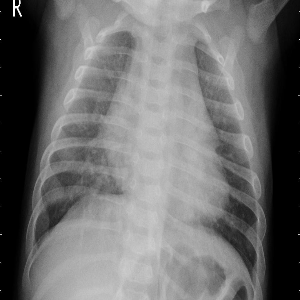

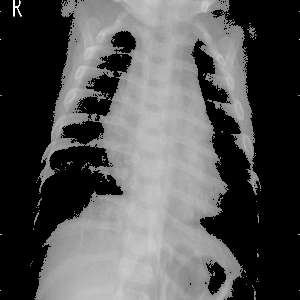

In [10]:
""" What I tried to do with images was to make them clearer with threshold and it has an signific effect on validation accuracy """

image = cv2.imread("/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person1637_virus_2834.jpeg")
image = cv2.resize(image,(300,300))
cv2_imshow(image)

_, thresh = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
cv2_imshow(thresh)

In [ ]:
def proccess_image_train(inputs):
  img = cv2.imread('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/' + bytes.decode(inputs.numpy()))
  img = cv2.resize(img,(300,300))
  _,img = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
  return img 

def get_image_train(inputs, outputs):
    img = tf.py_function(proccess_image_train, inp=[inputs], Tout=tf.int64)
    if(outputs == 0):
      outputs = [0,0,1]
    elif(outputs == 1):
      outputs = [0,1,0]
    else :
      outputs = [1,0,0]
    return img , outputs

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
X1 = X2 =  AUTOTUNE 

train_dataset = tf.data.Dataset.from_tensor_slices((train_input,train_label))
train_dataset = train_dataset.shuffle(len(train_input))
train_dataset = train_dataset.map(get_image_train,num_parallel_calls=X1)
train_dataset = train_dataset.batch(batch_size=16)
train_dataset = train_dataset.prefetch(buffer_size=X2)

In [ ]:
def proccess_image_test(inputs):
  img = cv2.imread('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/' + bytes.decode(inputs.numpy()))
  img = cv2.resize(img,(300,300))
  _,img = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
  return img 

def get_image_test(inputs, outputs):
    img = tf.py_function(proccess_image_test, inp=[inputs], Tout=tf.int64)
    if(outputs == 0):
      outputs = [0,0,1]
    elif(outputs == 1):
      outputs = [0,1,0]
    else :
      outputs = [1,0,0]
    return img , outputs

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
Y1 = Y2 =  AUTOTUNE 

test_dataset = tf.data.Dataset.from_tensor_slices((test_input,test_label))
test_dataset = test_dataset.shuffle(len(test_input))
test_dataset = test_dataset.map(get_image_test,num_parallel_calls=X1)
test_dataset = test_dataset.batch(batch_size=16)
test_dataset = test_dataset.prefetch(buffer_size=X2)

Building Model

In [ ]:
def create_model():
  image_input = keras.Input(shape = (300,300,3))
  cnn1 = keras.layers.Conv2D(64,(5,5),activation='relu')(image_input)
  max_pool_1 = keras.layers.MaxPool2D()(cnn1)
  cnn2 = keras.layers.Conv2D(32,(5,5),activation='relu')(max_pool_1)
  max_pool_2 = keras.layers.MaxPool2D()(cnn2)
  cnn3 = keras.layers.Conv2D(32,(4,4),activation='relu')(max_pool_2)
  max_pool_3 = keras.layers.MaxPool2D()(cnn3)
  cnn4 = keras.layers.Conv2D(16,(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(max_pool_3)
  max_pool_4= keras.layers.MaxPool2D()(cnn4)
  cnn5 = keras.layers.Conv2D(4,(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(max_pool_4)
  flatten = keras.layers.Flatten()(cnn5)
  dense_1 = keras.layers.Dense(128)(flatten)
  dropout_1 = keras.layers.Dropout(0.2)(dense_1)
  dense_2 = keras.layers.Dense(16)(dropout_1)
  dense_3 = keras.layers.Dense(3,activation = 'softmax')(dense_2)

  model = keras.Model(image_input,dense_3)
  tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics='acc') 

  return model

In [ ]:
model = create_model()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_tst/', monitor='val_acc',mode='max',verbose=1, save_best_only=True,save_weights_only=True)
history = model.fit(train_dataset,epochs = 30,validation_data=test_dataset,callbacks=[checkpoint_callback])

Epoch 1/30
330/331 [============================>.] - ETA: 0s - loss: 1.3801 - acc: 0.4752
Epoch 00001: val_acc improved from -inf to 0.38301, saving model to model_tst/
331/331 [==============================] - 72s 218ms/step - loss: 1.3800 - acc: 0.4752 - val_loss: 1.2637 - val_acc: 0.3830
Epoch 2/30
330/331 [============================>.] - ETA: 0s - loss: 1.1789 - acc: 0.4792
Epoch 00002: val_acc improved from 0.38301 to 0.39423, saving model to model_tst/
331/331 [==============================] - 71s 216ms/step - loss: 1.1787 - acc: 0.4794 - val_loss: 1.1294 - val_acc: 0.3942
Epoch 3/30
330/331 [============================>.] - ETA: 0s - loss: 1.1069 - acc: 0.4826
Epoch 00003: val_acc did not improve from 0.39423
331/331 [==============================] - 72s 216ms/step - loss: 1.1068 - acc: 0.4826 - val_loss: 1.1371 - val_acc: 0.3926
Epoch 4/30
330/331 [============================>.] - ETA: 0s - loss: 1.0413 - acc: 0.5072
Epoch 00004: val_acc improved from 0.39423 to 0.56891